# Fit GMM

## Load dependencies

In [1]:
import os
from glob import glob
from joblib import dump, load
import numpy as np
from scipy.stats import norm
from sklearn.mixture import GaussianMixture,BayesianGaussianMixture
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib import colors
%matplotlib inline

# Define some function to plot the model fit and extract component names

In [2]:
def plot_model_fit(model, comp_names, data, plot_full_model = False, y_min = 0,y_max = 0.007, x_min = -1000, x_max = 3000):
    data_min = data.min()
    data_max = data.max()
    model_x = np.arange(data_min, data_max+1).reshape(-1,1)

    
    #determine decision boundaries
    model_probs = model.predict_proba(model_x)
    decision_boundaries = model_x[np.argwhere(np.diff(model_probs.argmax(axis=1))!=0)]
    
    
    # Make data histogram
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[20,10])
    ax.hist(data, bins=int(data_max-data_min), density=True, alpha=0.5, color="#0070FF", label = 'Data')
    if plot_full_model:
        model_y = np.exp(model.score_samples(model_x))
        ax.plot(model_x, model_y, color="crimson",label="Full model")
    i = 0
    # plot gaussian components
    for comp in comp_names:
        m = model.means_[comp]
        c = model.covariances_[comp]
        w = model.weights_[comp]
        gauss = norm.pdf(model_x,loc= m,scale = np.sqrt(c))*w
        ax.plot(model_x,gauss, '--',label = comp_names[comp])
    # plot decision boundaries
    for xs in decision_boundaries:
        ax.axvline(x = xs)
        
    ax.set_ylim(y_min,y_max)
    ax.set_xlim(x_min,x_max)
    ax.legend()
    return(fig)

def plot_AIC_BIC(models,n_components,train,test, title = None):
    # plot the bic and aic criteria for train and test data
    fig,ax = plt.subplots(nrows = 1,ncols = 1,figsize = [10,5])
    ax.plot(n_components, [m.bic(train) for m in models], label = 'BIC train')
    ax.plot(n_components, [m.aic(train) for m in models], label = 'AIC train')
    ax.plot(n_components, [m.bic(test) for m in models], label = 'BIC test')
    ax.plot(n_components, [m.aic(test) for m in models], label = 'AIC test')
    ax.set_xticks(n_components)
    ax.legend()
    ax.set_title(title)
    return(fig)
    
from more_itertools import consecutive_groups
def find_ranges(iterable):
    """Yield range of consecutive numbers."""
    out = []
    for group in consecutive_groups(iterable):
        group = list(group)
        if len(group) == 1:
            out.append(group[0].item())
        else:
            out.append(group[0].item())
            out.append(group[-1].item())
    return out

def get_component_names(model,x_min = -1000,x_max = 3000):
    model_x = np.arange(x_min,x_max).reshape(-1,1)
    model_label = model.predict(model_x)
    # sort name order by mean of each component
    components = model.means_.ravel().argsort()
    # construct component names as ranges of HU values
    component_names = {}
    for comp in components:
        x_comp_ranges = find_ranges(model_x[model_label == comp])
        component_names[comp] = 'C_' + '_'.join(str(e) for e in x_comp_ranges)
    return component_names

## Load data per core and set parameters

In [3]:
data_dir = '../CT_data_Vandorpe/preproc'
model_dir = 'script_ouput/EM_models'
fig_dir_comp = 'figures/comp_selection'
fig_dir_fit = 'figures/model_fit'
no_samp_core = 10000000
min_no_comp = 2
max_no_comp = 20

In [6]:
cores = os.listdir(data_dir)
# store data per core in a dictionnary
data = {}
for core in cores:
    files = glob(data_dir +'/'+ core+'/*_slices.npy')
    data[core] = np.concatenate([np.load(f).ravel() for f in files])
data_pool = np.concatenate([data[core] for core in data])

## Subsample each core uniformly and derive a test and train set

In [7]:
train = {}
test = {}
np.random.seed(0)
for core in data:
    train[core], test[core] = train_test_split(np.random.choice(data[core], size = 2*no_samp_core), test_size = 0.5)
train_pool = np.concatenate([train[core] for core in data]).reshape(-1,1)
test_pool = np.concatenate([test[core] for core in data]).reshape(-1,1)

## Train GMM model on pooled data over a range of components and plot criteria

In [8]:
n_components = np.arange(min_no_comp,max_no_comp+1)
pool_models = [GaussianMixture(n,
                                   covariance_type='full',
                                   random_state=0,
                                   max_iter=1000).fit(train_pool) for n in n_components]

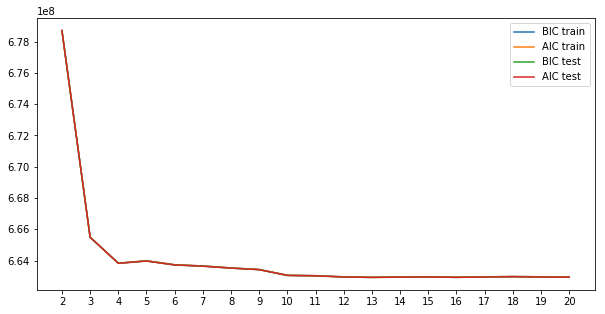

In [9]:
fig = plot_AIC_BIC(models=pool_models,n_components=n_components,train=train_pool,test=test_pool)
fig.savefig(fig_dir_comp+'/pool.eps',format = 'eps', bbox_inches = "tight")

## Determine best model and plot over histogram of entire dataset and of each core separately

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=1000,
        means_init=None, n_components=13, n_init=1, precisions_init=None,
        random_state=0, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)


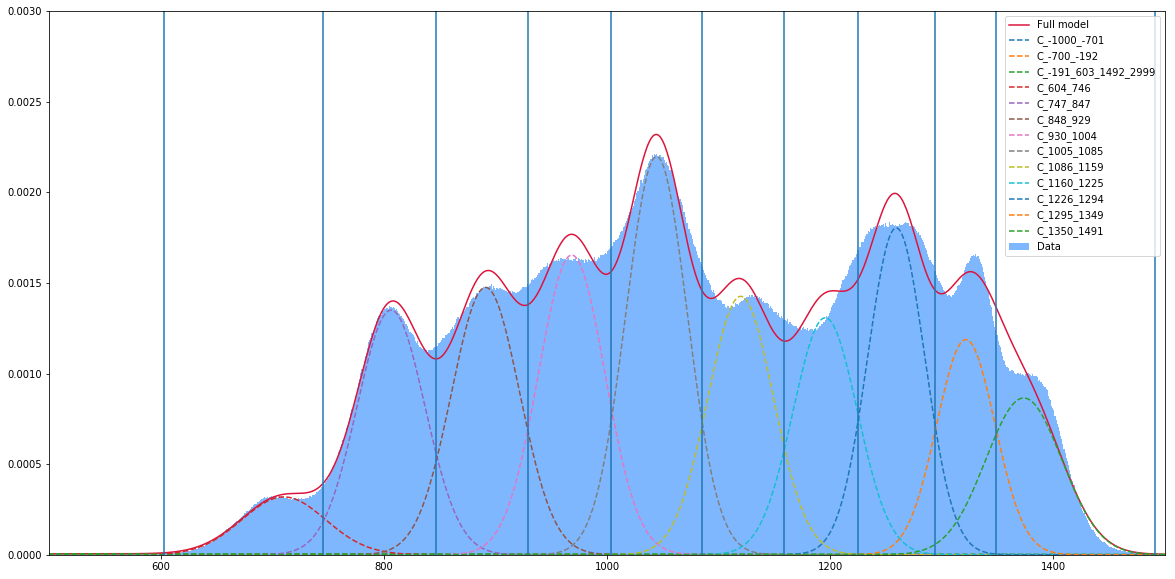

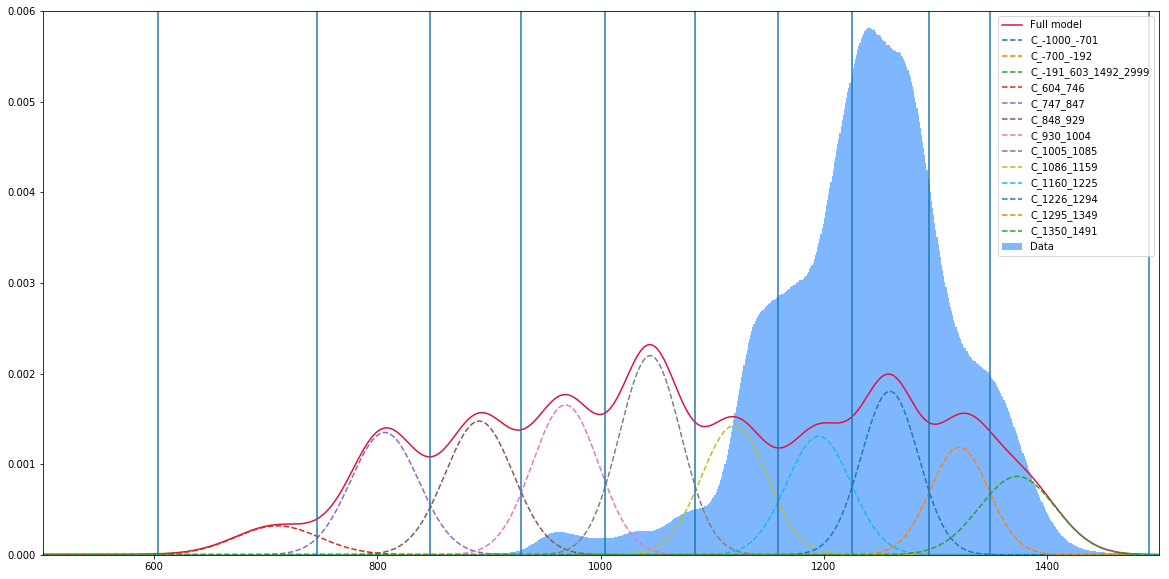

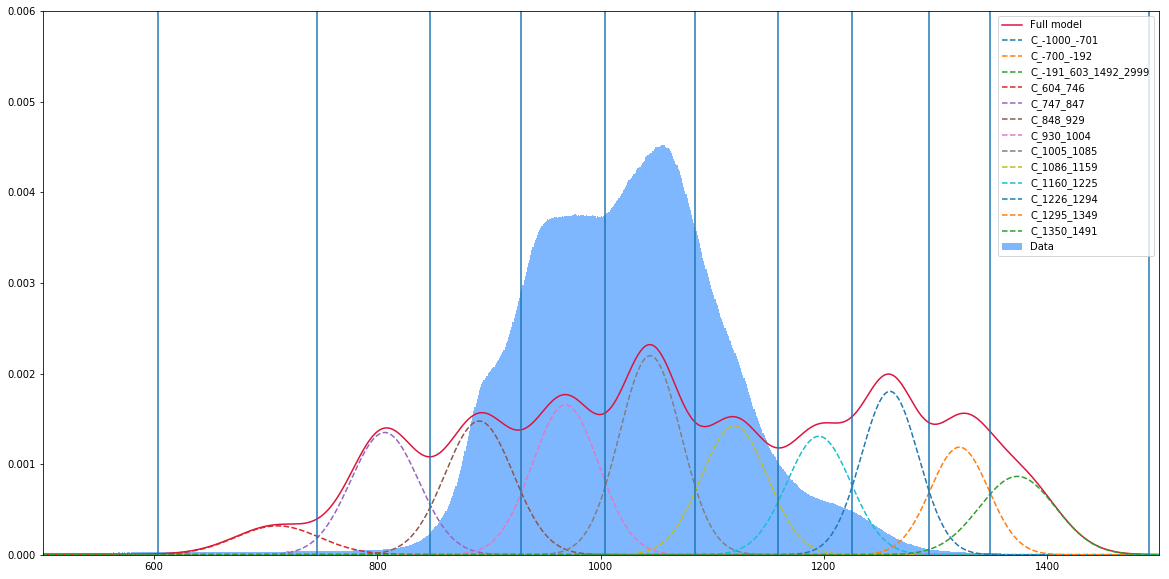

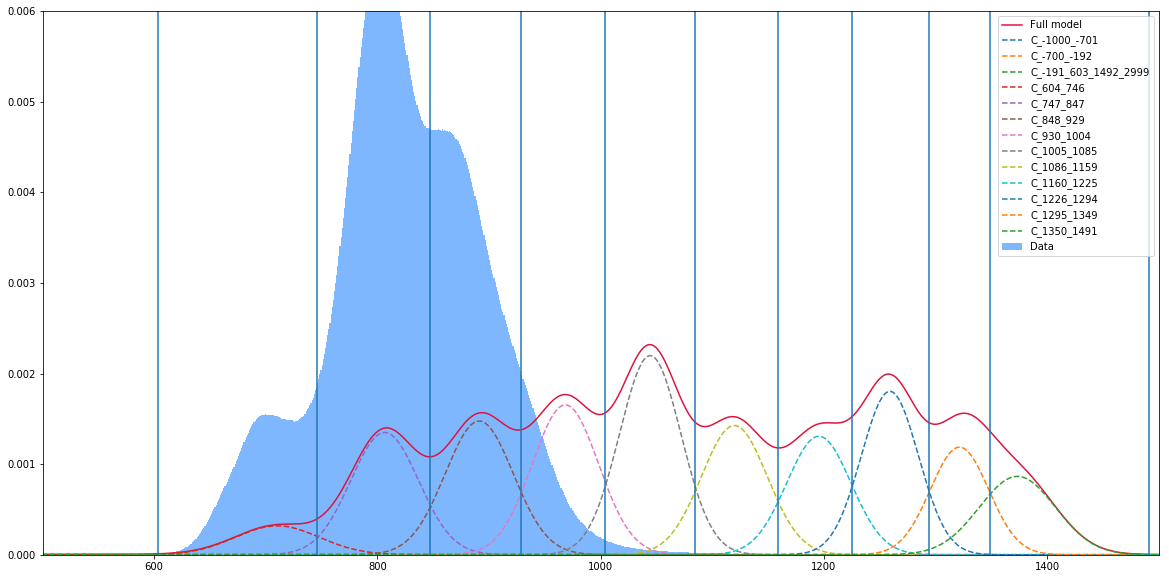

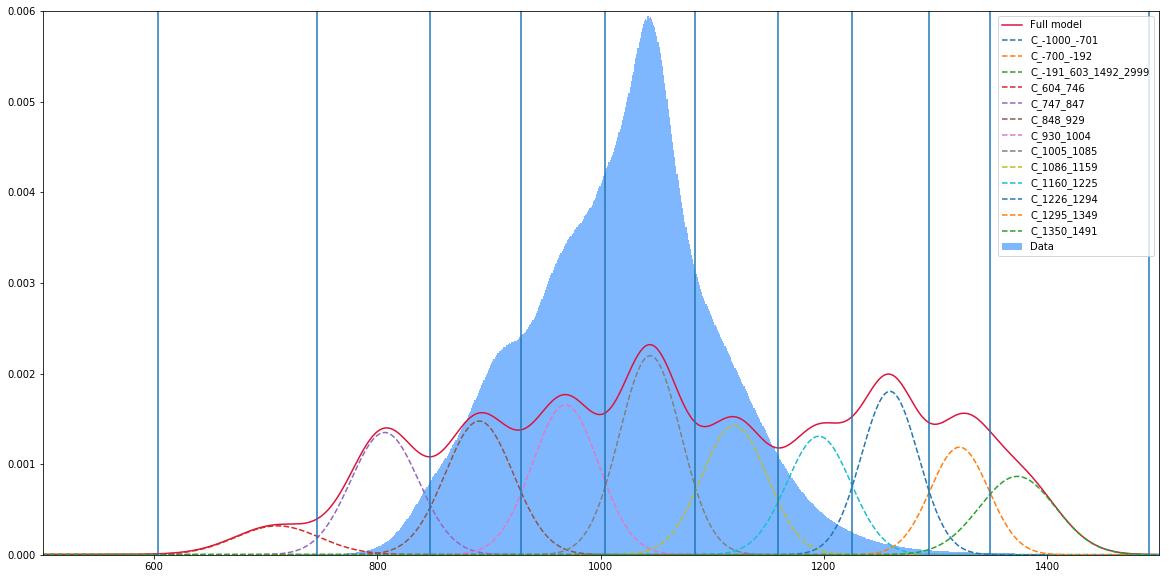

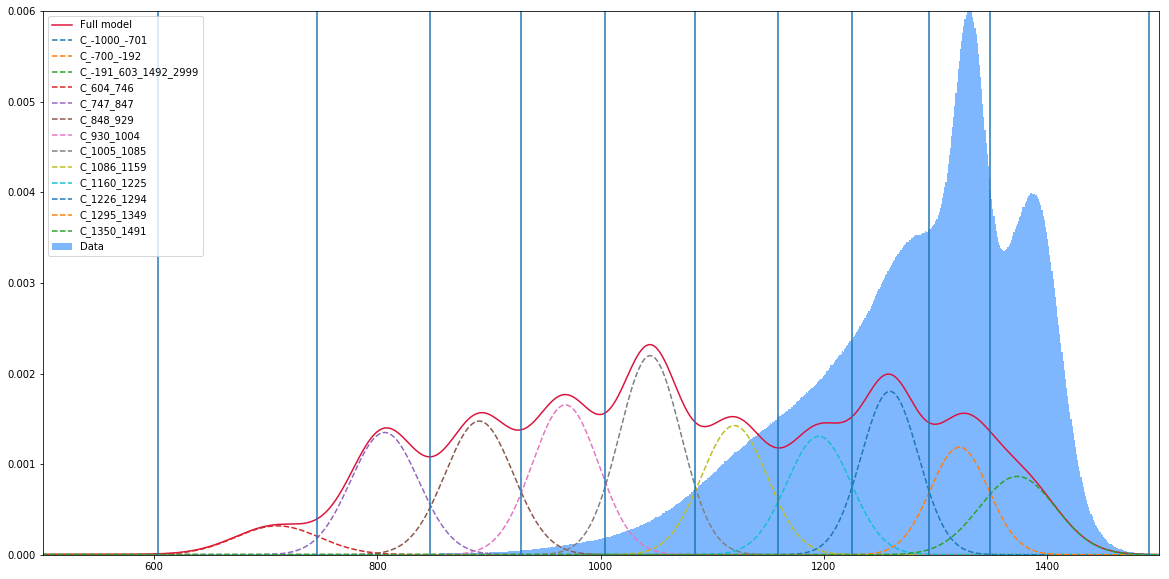

In [10]:
# determine best model
optim_pool = pool_models[13-min_no_comp]
optim_pool_names = get_component_names(optim_pool)

print(optim_pool)

# plot test distribution and model fit
#decision_boundaries = plot_model_fit(model = optim_pool,data = train_pool,y_max=0.003,plot_full_model=True)
fig = plot_model_fit(model = optim_pool,
                     comp_names=optim_pool_names,
                     data = test_pool,
                     y_max=0.003,x_min=500,x_max=1500,
                     plot_full_model=True)
fig.savefig(fig_dir_fit+'/pool_model_with_all_data.eps',format = 'eps', bbox_inches = "tight")

for core in cores:
    fig = plot_model_fit(model = optim_pool,
                         comp_names=optim_pool_names,
                         data = data[core],
                         y_max=0.006,x_min=500,x_max=1500,                                     
                                     plot_full_model=True)
    fig.savefig(fig_dir_fit+'/pool_model_and_'+core+'.eps',format = 'eps', bbox_inches = "tight")

## Make models for each core separately and plot criteria

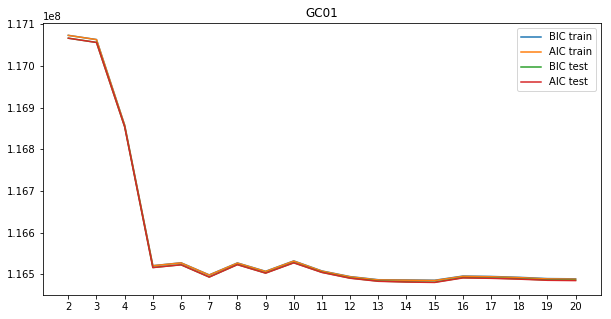

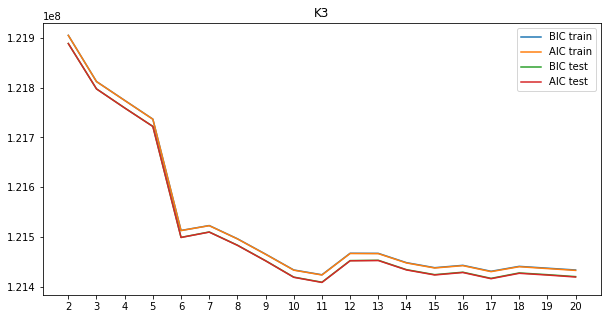

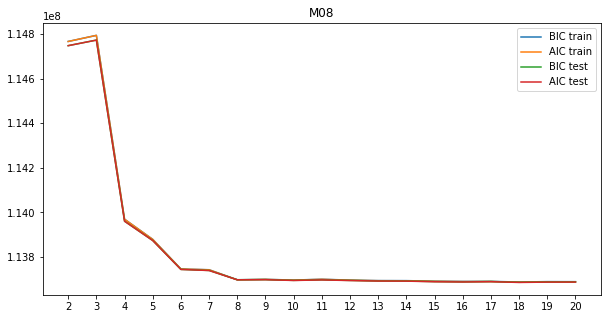

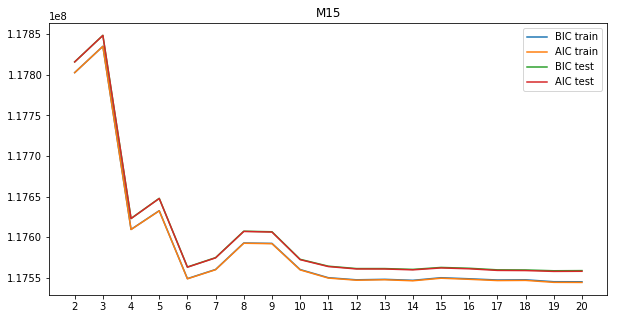

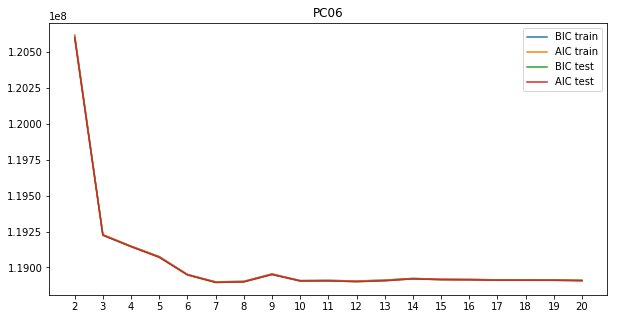

In [11]:
core_models = {}
for core in data:
    core_models[core] = [GaussianMixture(n,
                                         covariance_type='full',
                                         random_state=0,
                                         max_iter=1000).fit(train[core].reshape(-1,1)) for n in n_components]
    fig = plot_AIC_BIC(models=core_models[core],
                 n_components=n_components,
                 train=train[core].reshape(-1,1),
                 test=test[core].reshape(-1,1),
                 title=core)
    fig.savefig(fig_dir_comp+'/'+core+'.eps',format = 'eps', bbox_inches = "tight")

## Determine best models and plot over histogram

Optimal no of components for GC01: 5
GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=1000,
        means_init=None, n_components=5, n_init=1, precisions_init=None,
        random_state=0, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)
Optimal no of components for K3: 6
GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=1000,
        means_init=None, n_components=6, n_init=1, precisions_init=None,
        random_state=0, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)
Optimal no of components for M08: 6
GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=1000,
        means_init=None, n_components=6, n_init=1, precisions_init=None,
        random_state=0, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)
Optimal no of components for M15: 7
GaussianMixture(cov

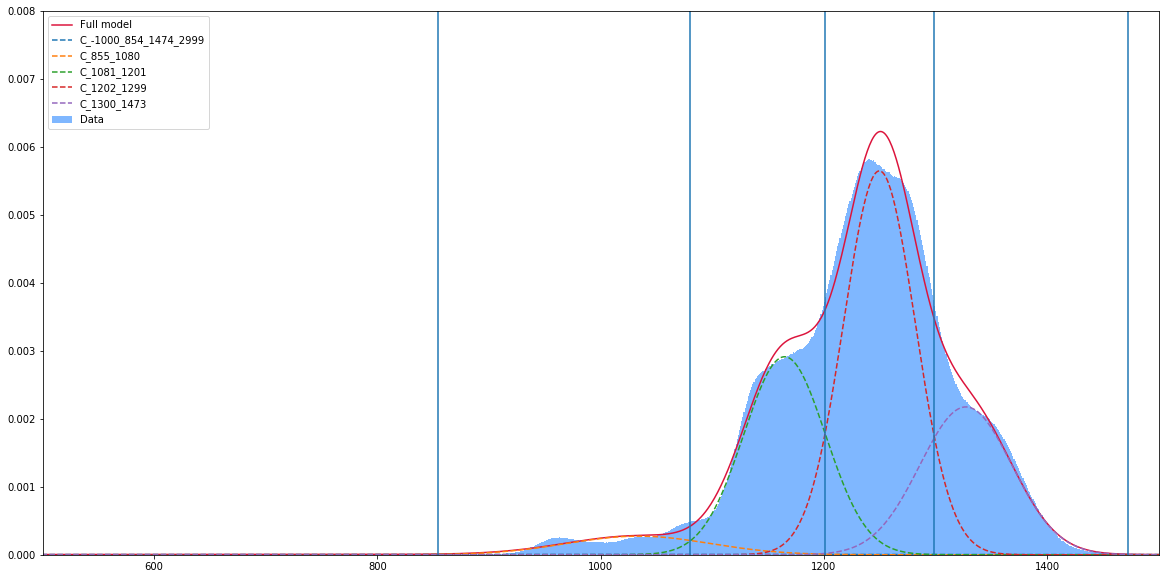

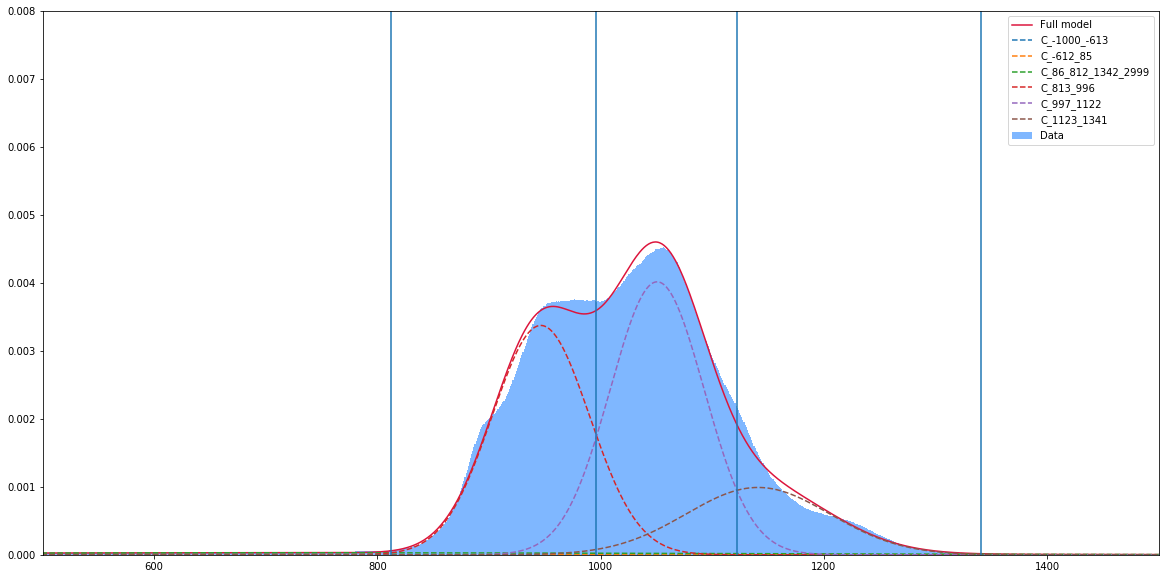

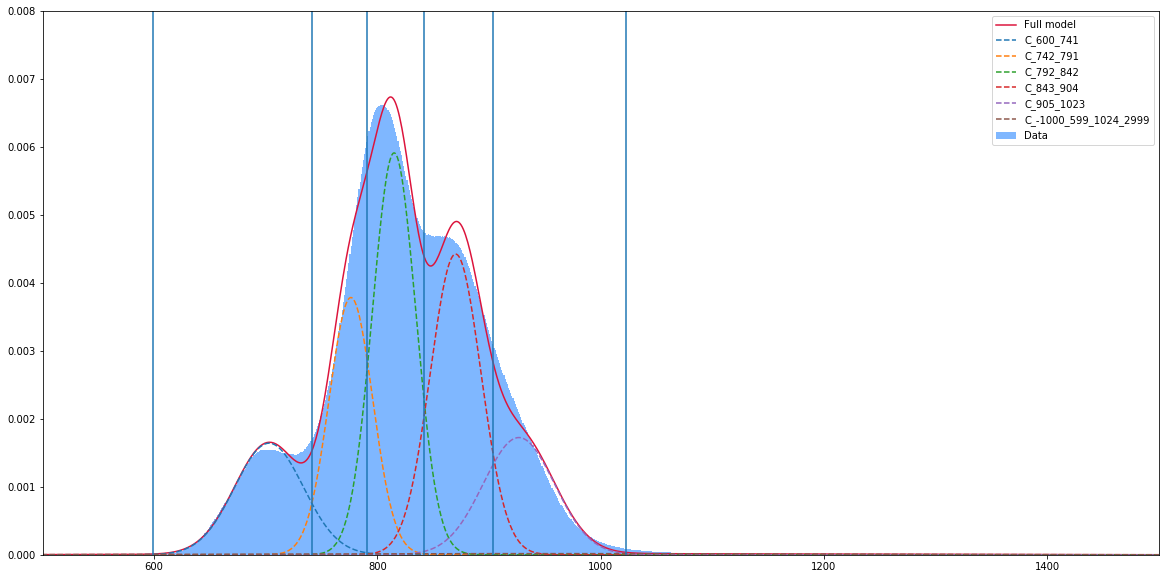

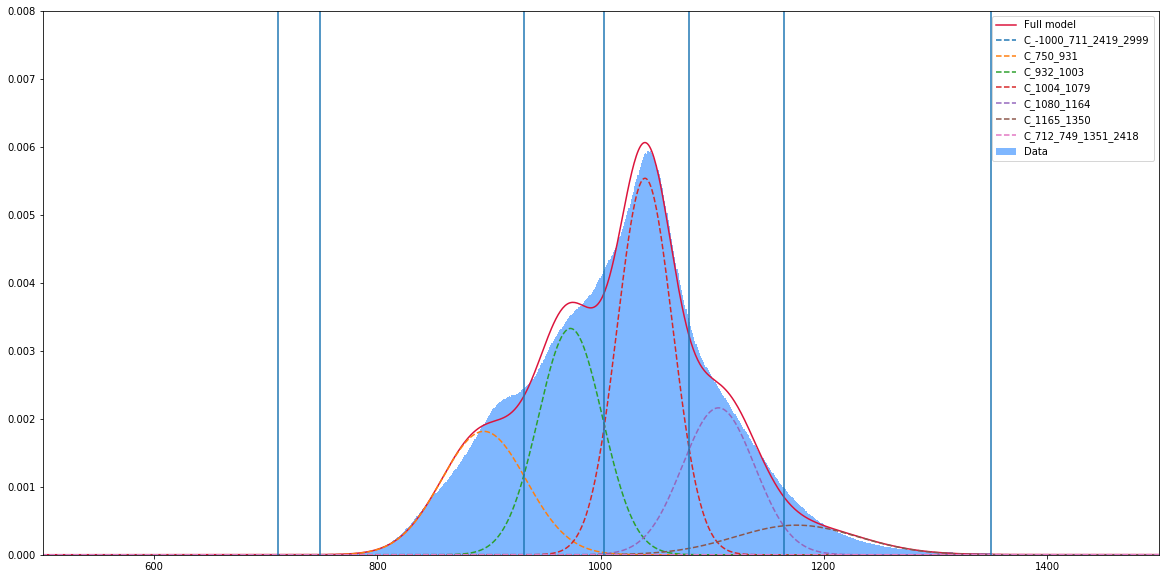

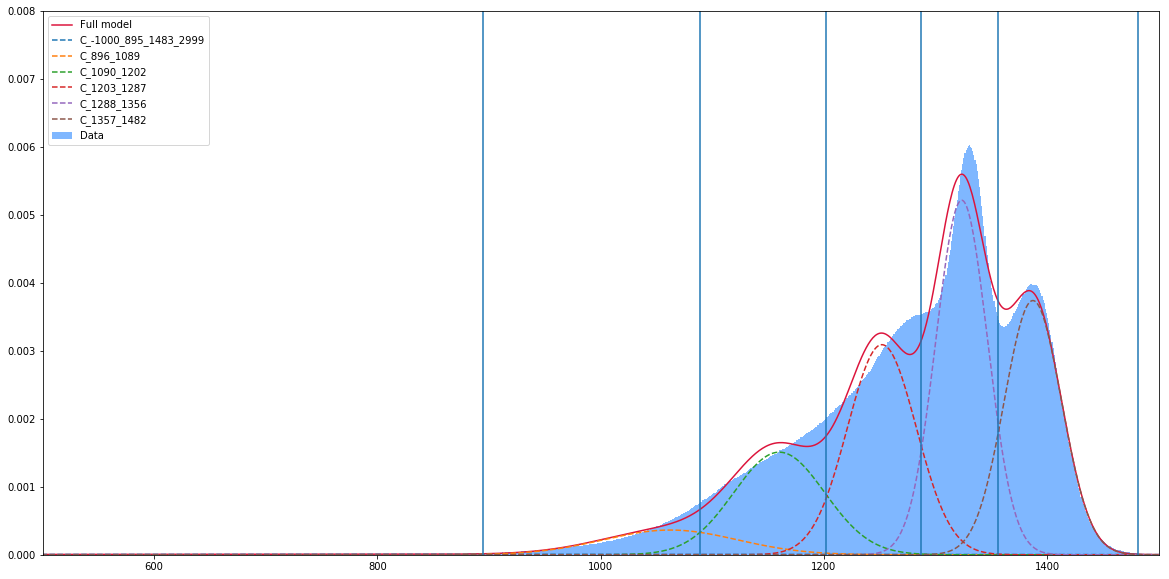

In [12]:
optim_components = {'GC01': 5,'K3': 6,'M08':6,'M15':7,'PC06':6} # compoents to take
optim_core_models = {}
optim_core_models_names = {}
for core in data:
    print("Optimal no of components for " + core + ": "+str(optim_components[core]))
    # select optimal number of components
    optim_core_models[core] = core_models[core][optim_components[core]-min_no_comp]
    # get the component names
    optim_core_models_names[core] = get_component_names(optim_core_models[core])
    print(optim_core_models[core])
    # plot distribution and model fit
    fig = plot_model_fit(model = optim_core_models[core],
                                         comp_names=optim_core_models_names[core],
                                         data = data[core],
                                         y_max=0.008,x_min=500,x_max=1500,
                                         plot_full_model=True)
    fig.savefig(fig_dir_fit+'/core_model_'+core+'.eps',format = 'eps', bbox_inches = "tight")

## Save the optimal models

In [13]:
dump((optim_pool, optim_pool_names), model_dir+'/optim_pool.joblib')
dump((optim_core_models, optim_core_models_names), model_dir + '/optim_core_models.joblib')

['script_ouput/EM_models/optim_core_models.joblib']

## Output the entire list of models

In [14]:
dump(pool_models, model_dir+'/all_pool.joblib')
dump(core_models, model_dir+'/all_core.joblib')

['script_ouput/EM_models/all_core.joblib']